In [ ]:
# Import Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [4]:
#load dataset
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
dataset=tf.keras.preprocessing.image_dataset_from_directory('minet',shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 957 files belonging to 7 classes.


In [5]:
class_names=dataset.class_names
class_names

['biotite',
 'bornite',
 'chrysocolla',
 'malachite',
 'muscovite',
 'pyrite',
 'quartz']

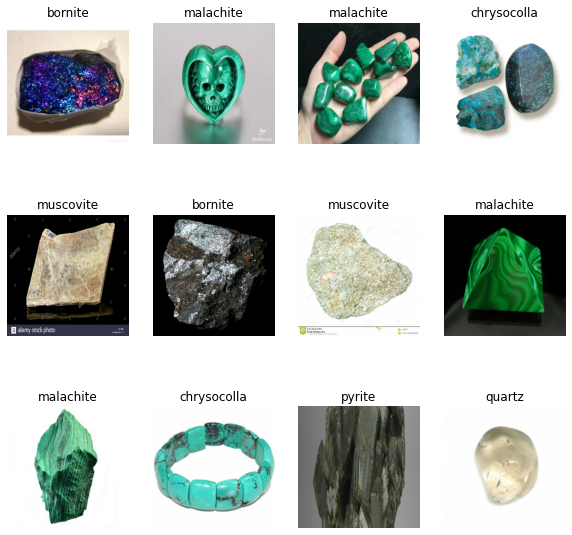

In [6]:
#Display any 12 images randomly
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1): # take(1) represent one batch which contain 32 image
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8')) #as shuffle is true so every time it shows different image while executing
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [7]:
#split the Dataset
# 80%=training dataset
# 20%= testing dataset(10%=validation ,10%=test)
train_size=0.8
len(dataset)*train_size

24.0

In [8]:
train_ds=dataset.take(24)
len(train_ds)

24

In [9]:
test_ds=dataset.skip(24)
len(test_ds)

6

In [10]:
val_size=0.1
len(dataset)*val_size

3.0

In [11]:
val_ds=test_ds.take(3)
len(val_ds)

3

In [12]:
test_ds=test_ds.skip(3)
len(test_ds)

3

In [13]:
#splitting ds using python function
def get_datadet_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds


In [14]:
train_ds,val_ds,test_ds=get_datadet_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))


24
3
3


In [15]:
# dataset is optimized for training performance
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) #it will read the image from disk and then for the next iteration when we need that image it will keep it in memory
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
#Building the Model
#Creating a Layer for Resizing and Normalization
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
#DATA Augmentation
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
#Model Architecture
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [19]:
#Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30
)

Epoch 1/30
24/24 [==============================] - 71s 2s/step - loss: 1.6828 - accuracy: 0.2301 - val_loss: 1.4424 - val_accuracy: 0.3854
Epoch 2/30
24/24 [==============================] - 58s 2s/step - loss: 1.4671 - accuracy: 0.4065 - val_loss: 1.5744 - val_accuracy: 0.3229
Epoch 3/30
24/24 [==============================] - 57s 2s/step - loss: 1.3707 - accuracy: 0.4222 - val_loss: 1.1776 - val_accuracy: 0.5104
Epoch 4/30
24/24 [==============================] - 56s 2s/step - loss: 1.1598 - accuracy: 0.5477 - val_loss: 1.0785 - val_accuracy: 0.6146
Epoch 5/30
24/24 [==============================] - 55s 2s/step - loss: 1.0439 - accuracy: 0.5935 - val_loss: 1.0086 - val_accuracy: 0.6250
Epoch 6/30
24/24 [==============================] - 55s 2s/step - loss: 0.9723 - accuracy: 0.6065 - val_loss: 0.9816 - val_accuracy: 0.5729
Epoch 7/30
24/24 [==============================] - 55s 2s/step - loss: 0.9353 - accuracy: 0.6209 - val_loss: 0.9499 - val_accuracy: 0.6354
Epoch 8/30
24/24 [==

In [68]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 7s 232ms/step - loss: 0.0940 - accuracy: 0.9792


In [69]:
scores # first parameter is loss and second is accuracy

[0.09398164600133896, 0.9791666865348816]

In [70]:
#Plotting the Accuracy and Loss Curves
history

In [72]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 24}

In [74]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [75]:
print(type(history.history['loss']))
print(len(history.history['loss']))
print(history.history['loss'][:5] )# show loss for first 5 epochs

<class 'list'>
30
[0.811968982219696, 0.8589010238647461, 0.7948222756385803, 0.7275709509849548, 0.6903394460678101]


In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

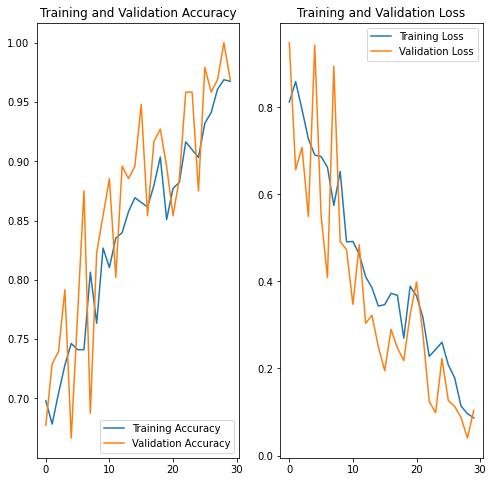

In [77]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc, label='Training Accuracy')
plt.plot(range(30), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss, label='Training Loss')
plt.plot(range(30), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: bornite
predicted label: bornite


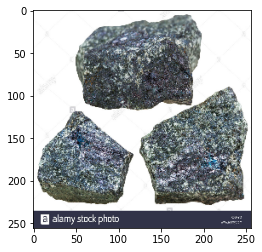

In [81]:
#Run prediction on a sample image
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])   #batch_prediction gives the predicted image index in array , np.argmax gives maximum int in that array which act as index for class_names 

In [82]:
#Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

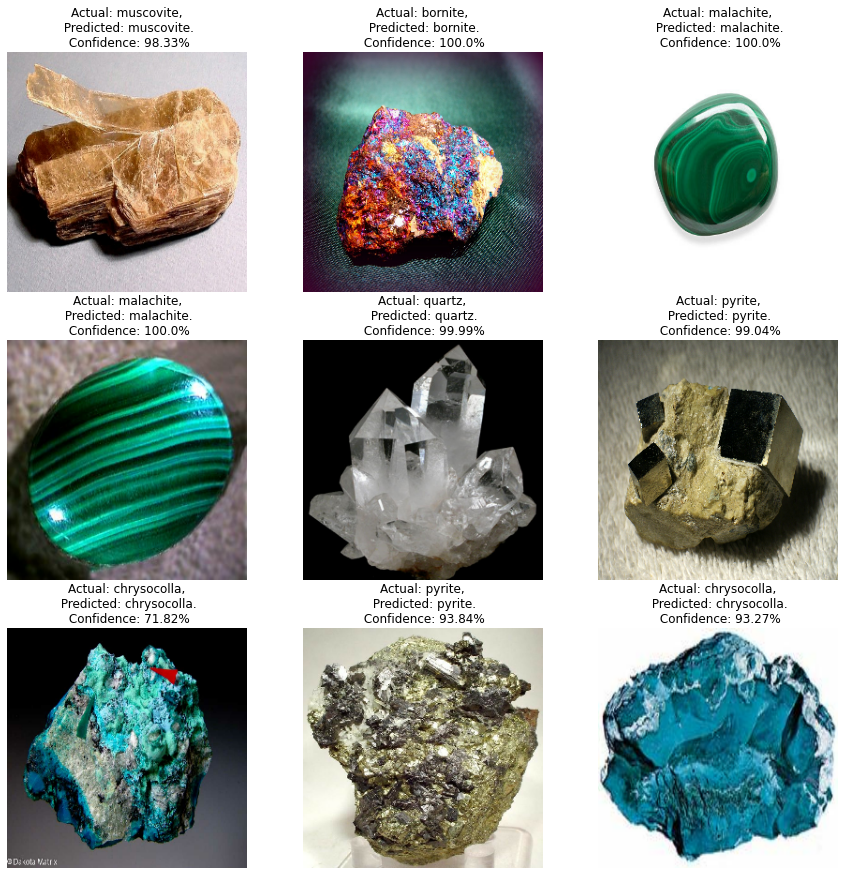

In [83]:
#Now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [90]:
#saving the model
import os
model_version=max([int(i) for i in os.listdir("../model") + [0]])+1
model.save(f"../model/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/model'

In [21]:
model.save('mineral_model')

INFO:tensorflow:Assets written to: mineral_model\assets
